# Imports and Setup

In [ ]:
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import brown
from tqdm.notebook import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix

In [ ]:
sns.set_theme()
SEED = 0
def setSeed(seed):
    np.random.seed(seed)
    random.seed(seed)

setSeed(SEED)


In [ ]:
# Mean and Log Functions
mean = lambda l : sum(l) / len(l)
def log(x):
    if x == 0:
        return -np.inf
    else:
        return np.log(x)


In [ ]:
# Plot and Print Functions
def plotCM(cm):
    df_cm = pd.DataFrame(cm, index = [t for t in TAGS[1:]], columns = [t for t in TAGS[1:]])
    plt.figure(figsize = (15, 10))
    sns.heatmap(df_cm, annot = True, cmap = plt.cm.Blues)
    plt.show()

def printClasswise(metrics):
    for i in range(N_TAGS - 1):
        print(f"{TAGS[i+1]}: {metrics[i]:.3f}", end = ", ")
    print()


# Data Handling

In [ ]:
import nltk
nltk.download("brown")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
# Loading the Data
def load():
    data = brown.tagged_sents(tagset = "universal")
    data = list(data)
    return data

In [ ]:
def preprocess(data):
    # Append (^, -) to each data point to indicate the start of a sentence / POS tag sequence
    for s in data:
        s.insert(0, ("^", "-")) # '^' for sentence, '-' for tag


def createFolds(data, k):
    # Randomly shuffles the data and returns k equal sized segments for k-fold cross validation
    n = len(data)
    n_split = n // k # approx split size
    random.shuffle(data)
    folds = []
    for start in range(0, n, n_split):
        end = min(start + n_split, n)
        fold = data[start : end]
        folds.append(fold)
    return folds

def getSentence(d):
    # Given data point d print the sentence contained in it
    s = " ".join([i[0] for i in d])
    return s

def getTags(d):
    # Given data point d return the tag sequence
    t = " ".join([i[1] for i in d])
    return t


def buildTags(data):
    # Compute the set of unique tags present in the data
    tags = set()
    for s in data:
        for w, t in s:
            tags.add(t)
    tags = sorted(list(tags))
    return tags


def buildVocab(data):
    # Compute the set of unique words present in the data, lowercasing is not applied
    vocab = set()
    for s in data:
        for w, t in s:
            vocab.add(w)
    vocab = sorted(list(vocab))
    return vocab

# HMM Model

In [ ]:
def buildFreqs(data):
    # Computes the frequency matrices for tags, (tag, tag) and (tag, word)

    tf = defaultdict(int)
    ef = defaultdict(int)
    tag_freq = defaultdict(int)

    for s in data:
        p = "-" # the initial value of the previous tag (this acts as the tag for ^: the sentence start)
        for w, t in s:
            tf[(p, t)] += 1 # auto-init to 0 when key doesn't exit
            ef[(t, w)] += 1 # each word has a corresponding tag
            tag_freq[t] += 1
            p = t

    return tf, ef, tag_freq


def buildMatrices(tf, ef, tag_freq):
    # Builds the transition and emmission matrices from the frequency matrices while applying smoothing

    tm = np.zeros((N_TAGS, N_TAGS))
    em = np.zeros((N_TAGS, N_VOCAB))

    alpha = 1e-8 # handles values when certain combinations of tags / bigrams don't occur in the data
    # Reference for this: http://ivan-titov.org/teaching/nlmi-15/lecture-4.pdf

    for i in range(N_TAGS):

        # Build the transition matrix
        for j in range(N_TAGS):
            ti = id2tag(i)
            tj = id2tag(j)
            tm[i, j] = (tf[(ti, tj)] + alpha) / (tag_freq[ti] + alpha*N_TAGS)

        # Build the emission matrix
        for j in range(N_VOCAB):
            ti = id2tag(i)
            wj = id2word(j)
            em[i, j] = (ef[(ti, wj)] + alpha) / (tag_freq[ti] + alpha*N_VOCAB)

    return tm, em


def train(data):
    tf, ef, tag_freq = buildFreqs(data)
    tm, em = buildMatrices(tf, ef, tag_freq)
    return tm, em


In [ ]:
def viterbi(tm, em, s):
    # Performs viterbi decoding on sentence s, which is assumed to be a list of words starting from ^

    n_sent = len(s) # length of the sentence to be decoded

    # Create tables to be used for dynamic programming
    best_probs = np.zeros((n_sent, N_TAGS)) # stores the log probabilities to ensure values don't become too small by repeated multiplications later
    best_tags  = np.zeros((n_sent, N_TAGS))

    # Initialize the first row of best_probs
    for i in range(N_TAGS):
        best_probs[0, i] = log(tm[0, i]) + log(em[i, word2id(s[0])])

    # Forward
    for i in range(1, n_sent):

        w_prev = s[i - 1]
        w = s[i]

        for j in range(N_TAGS):
            pmax = -np.inf
            best_tag = None # stores index of the best tag for the current word
            for k in range(N_TAGS):
                p = best_probs[i - 1, k] + log(tm[k, j])
                if p > pmax:
                    pmax = p
                    best_tag = k

            try:
                wid = word2id(w)
            except KeyError: # handles KeyError
                wid = -1 # word not in vocab

            if wid != -1:
                best_probs[i, j] = pmax + log(em[j, wid]) # the second term is constant when taking argmax over k
            else:
                # In this case the bigram doesn't occur in the training data
                best_probs[i, j] = pmax + log(em.min()) # assign the minimum emmission probability to this tag

            best_tags[i, j] = best_tag

    pred = [] # the tag predictions for the sentence

    # Get the last tag
    pmax = -np.inf
    end_tag = None
    for i in range(N_TAGS):
        if best_probs[-1, i] > pmax:
            pmax = best_probs[-1, i]
            end_tag = i
    pred.append(end_tag)


    # Backtrack
    t = end_tag # init
    for i in range(n_sent - 1, 1, -1):
        t = int(best_tags[i, t])
        pred.append(t)

    pred.reverse() # as we have built this starting from the back

    return pred

# Training & Evaluation

In [ ]:
def evaluate(data, tm, em):
    # Evaluates the trained HMM model on the data

    tags_true = []
    tags_pred = []

    for d in tqdm(data):
        s = [i[0] for i in d]
        t_true = [tag2id(i[1]) for i in d[1:]] # ignoring "-" at the start
        t_pred = viterbi(tm, em, s)
        tags_true += t_true
        tags_pred += t_pred

    return tags_true, tags_pred

In [ ]:
# Load the required data
data = load()
preprocess(data)

N = len(data)
print(f"Length: {N:,}")

Length: 57,340


In [ ]:
TAGS = buildTags(data)
N_TAGS = len(TAGS)
print(f"Tagset size: {N_TAGS} (includes the dummy '-' tag)")
print(TAGS)

# Maps
id2tag = lambda i : TAGS[i]
tagmap = {TAGS[i]:i for i in range(N_TAGS)}
tag2id = lambda i : tagmap[i]

Tagset size: 13 (includes the dummy '-' tag)
['-', '.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [ ]:
# Print some random statements and the corresponding tags
for i in random.sample(range(N), 10):
    print(getSentence(data[i]))
    print(getTags(data[i]))
    print()

^ Eddie shouted .
- NOUN VERB .

^ We therefore leave the writer to the enjoyment of the unenvied reputation which the personal abuse he has heaped on us will entitle him to from the low and vulgar herd to which he belongs '' .
- PRON ADV VERB DET NOUN ADP DET NOUN ADP DET ADJ NOUN DET DET ADJ NOUN PRON VERB VERB ADP PRON VERB VERB PRON ADP ADP DET ADJ CONJ ADJ NOUN ADP DET PRON VERB . .

^ Lots of throttle .
- NOUN ADP NOUN .

^ The major areas of self-help are the following : ( A ) the effective mobilizing of resources .
- DET ADJ NOUN ADP NOUN VERB DET NOUN . . DET . DET ADJ VERB ADP NOUN .

^ Some Dallas investment firms got only 100 shares , for all of their customers .
- DET NOUN NOUN NOUN VERB ADJ NUM NOUN . ADP PRT ADP DET NOUN .

^ The ship halted .
- DET NOUN VERB .

^ ) The full forms can be derived from such information just prior to the lookup of the form in the text-form list .
- . DET ADJ NOUN VERB VERB VERB ADP ADJ NOUN ADV ADV ADP DET NOUN ADP DET NOUN ADP DET NOUN NOU

In [ ]:
folds = createFolds(data, k = 5)

In [ ]:
# Initialize the metrics

# Avg cm
avg_cm = 0 # ignoring the dummy tag added at the start of each sentence

# Initialize average metrics
avg_acc = 0
avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_f05 = 0
avg_f2 = 0

# Average tagwise metrics
avg_prec_tagwise = 0
avg_rec_tagwise = 0
avg_f1_tagwise = 0

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.922, ADP: 0.951, ADV: 0.912, CONJ: 0.993, DET: 0.968, NOUN: 0.962, NUM: 0.968, PRON: 0.955, PRT: 0.910, VERB: 0.974, X: 0.801, 
Tag-wise recall:
.: 1.000, ADJ: 0.913, ADP: 0.968, ADV: 0.898, CONJ: 0.995, DET: 0.987, NOUN: 0.955, NUM: 0.910, PRON: 0.987, PRT: 0.905, VERB: 0.951, X: 0.569, 
Tag-wise F1:
.: 0.998, ADJ: 0.918, ADP: 0.959, ADV: 0.905, CONJ: 0.994, DET: 0.978, NOUN: 0.958, NUM: 0.938, PRON: 0.971, PRT: 0.908, VERB: 0.962, X: 0.665, 
Accuracy: 0.9599018637283174
Avg. precision: 0.9427395188765629
Avg. recall: 0.9198466854404789
Avg. f_0.5: 0.9369136127574209
Avg. f1: 0.9295297377883567
Avg. f2: 0.923393706253242


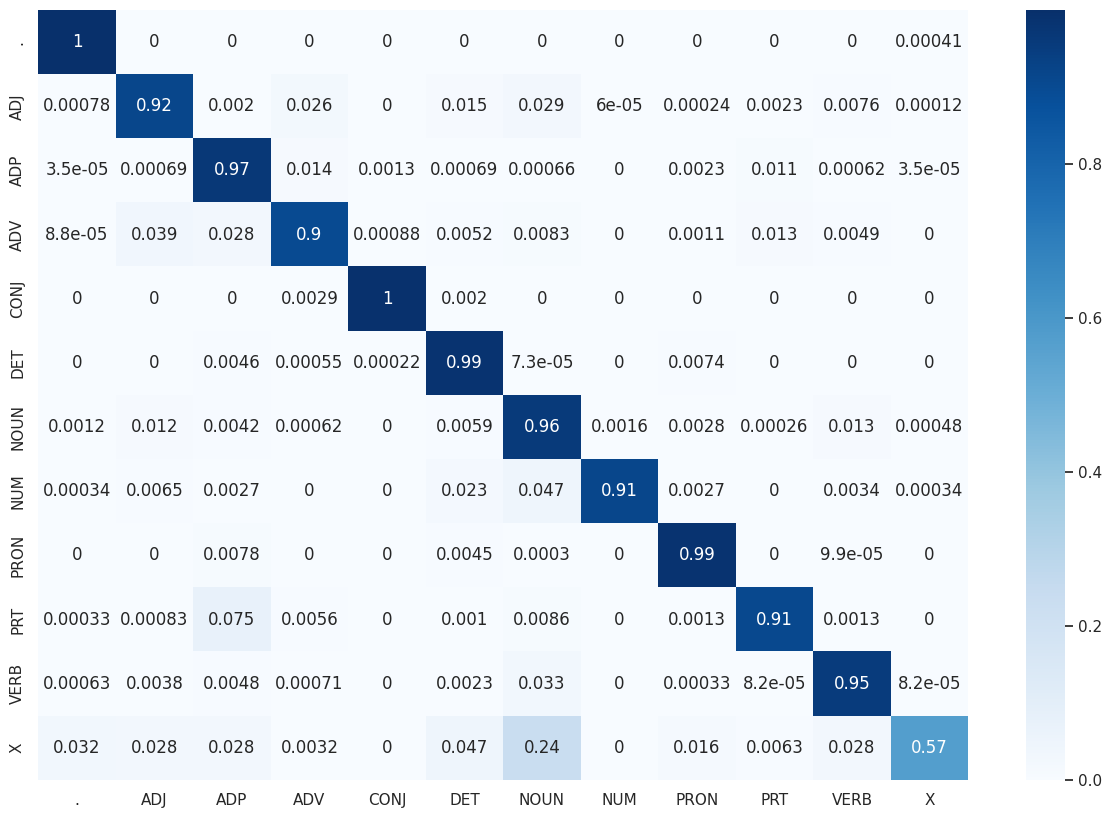

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.919, ADP: 0.948, ADV: 0.907, CONJ: 0.993, DET: 0.967, NOUN: 0.962, NUM: 0.975, PRON: 0.954, PRT: 0.905, VERB: 0.973, X: 0.800, 
Tag-wise recall:
.: 1.000, ADJ: 0.911, ADP: 0.968, ADV: 0.898, CONJ: 0.995, DET: 0.987, NOUN: 0.953, NUM: 0.916, PRON: 0.984, PRT: 0.906, VERB: 0.949, X: 0.446, 
Tag-wise F1:
.: 0.998, ADJ: 0.915, ADP: 0.958, ADV: 0.903, CONJ: 0.994, DET: 0.977, NOUN: 0.958, NUM: 0.945, PRON: 0.969, PRT: 0.906, VERB: 0.961, X: 0.573, 
Accuracy: 0.9588758485494405
Avg. precision: 0.941687604026229
Avg. recall: 0.9094106998518242
Avg. f_0.5: 0.9319172909504773
Avg. f1: 0.921231579768881
Avg. f2: 0.913494046011619


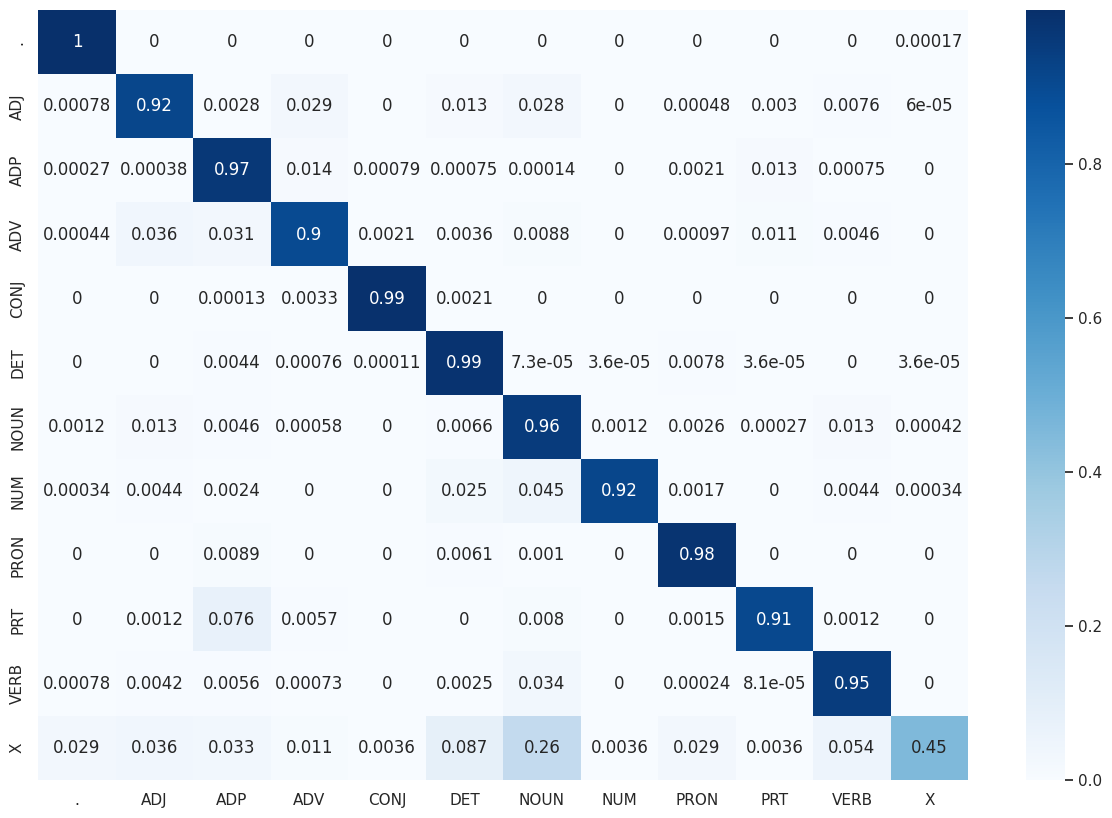

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.922, ADP: 0.951, ADV: 0.909, CONJ: 0.993, DET: 0.967, NOUN: 0.962, NUM: 0.970, PRON: 0.955, PRT: 0.910, VERB: 0.970, X: 0.796, 
Tag-wise recall:
.: 1.000, ADJ: 0.910, ADP: 0.970, ADV: 0.893, CONJ: 0.996, DET: 0.986, NOUN: 0.952, NUM: 0.909, PRON: 0.985, PRT: 0.906, VERB: 0.952, X: 0.482, 
Tag-wise F1:
.: 0.998, ADJ: 0.916, ADP: 0.960, ADV: 0.901, CONJ: 0.994, DET: 0.976, NOUN: 0.957, NUM: 0.938, PRON: 0.970, PRT: 0.908, VERB: 0.961, X: 0.600, 
Accuracy: 0.9590175602054946
Avg. precision: 0.9417496808904041
Avg. recall: 0.9117487047911529
Avg. f_0.5: 0.9332480841115743
Avg. f1: 0.9233978648055176
Avg. f2: 0.91586920110226


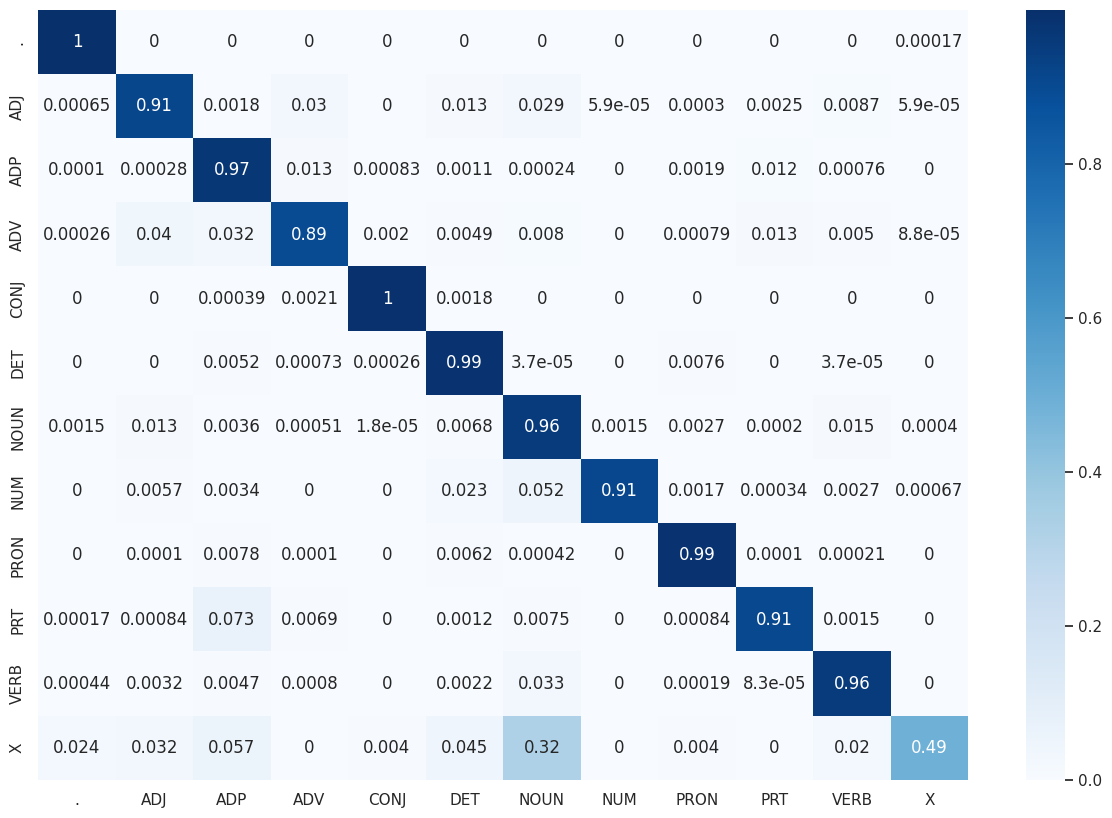

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.918, ADP: 0.952, ADV: 0.909, CONJ: 0.992, DET: 0.967, NOUN: 0.961, NUM: 0.969, PRON: 0.957, PRT: 0.904, VERB: 0.972, X: 0.925, 
Tag-wise recall:
.: 1.000, ADJ: 0.911, ADP: 0.968, ADV: 0.895, CONJ: 0.994, DET: 0.987, NOUN: 0.952, NUM: 0.917, PRON: 0.984, PRT: 0.914, VERB: 0.950, X: 0.484, 
Tag-wise F1:
.: 0.998, ADJ: 0.915, ADP: 0.960, ADV: 0.902, CONJ: 0.993, DET: 0.977, NOUN: 0.957, NUM: 0.942, PRON: 0.970, PRT: 0.909, VERB: 0.961, X: 0.635, 
Accuracy: 0.9590206129820691
Avg. precision: 0.9518441972152293
Avg. recall: 0.9129619630405567
Avg. f_0.5: 0.939450081901489
Avg. f1: 0.9265249298536374
Avg. f2: 0.9175613157308738


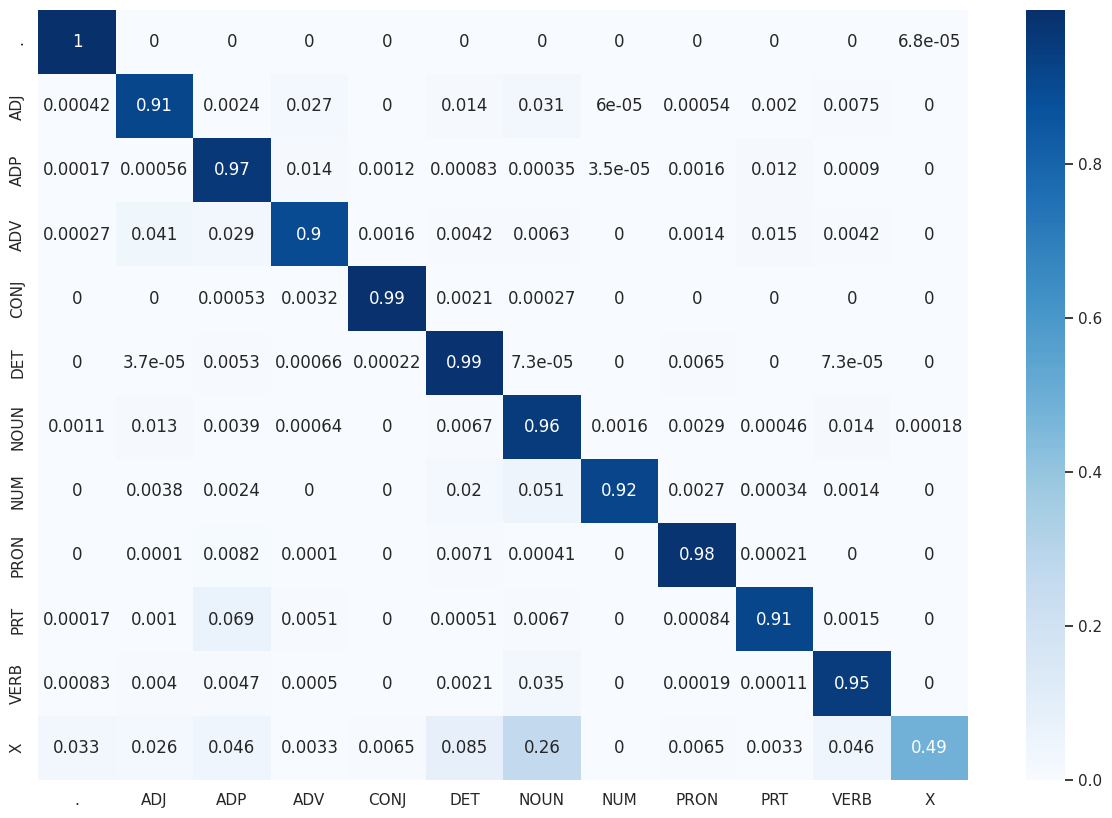

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.995, ADJ: 0.920, ADP: 0.949, ADV: 0.907, CONJ: 0.993, DET: 0.968, NOUN: 0.963, NUM: 0.973, PRON: 0.953, PRT: 0.907, VERB: 0.972, X: 0.737, 
Tag-wise recall:
.: 1.000, ADJ: 0.911, ADP: 0.968, ADV: 0.892, CONJ: 0.996, DET: 0.987, NOUN: 0.952, NUM: 0.913, PRON: 0.985, PRT: 0.903, VERB: 0.952, X: 0.498, 
Tag-wise F1:
.: 0.998, ADJ: 0.915, ADP: 0.959, ADV: 0.899, CONJ: 0.994, DET: 0.977, NOUN: 0.958, NUM: 0.942, PRON: 0.969, PRT: 0.905, VERB: 0.962, X: 0.594, 
Accuracy: 0.9590538771573255
Avg. precision: 0.9364514348031666
Avg. recall: 0.9129900568512118
Avg. f_0.5: 0.9302710719789281
Avg. f1: 0.9226512425949035
Avg. f2: 0.9164875072622293


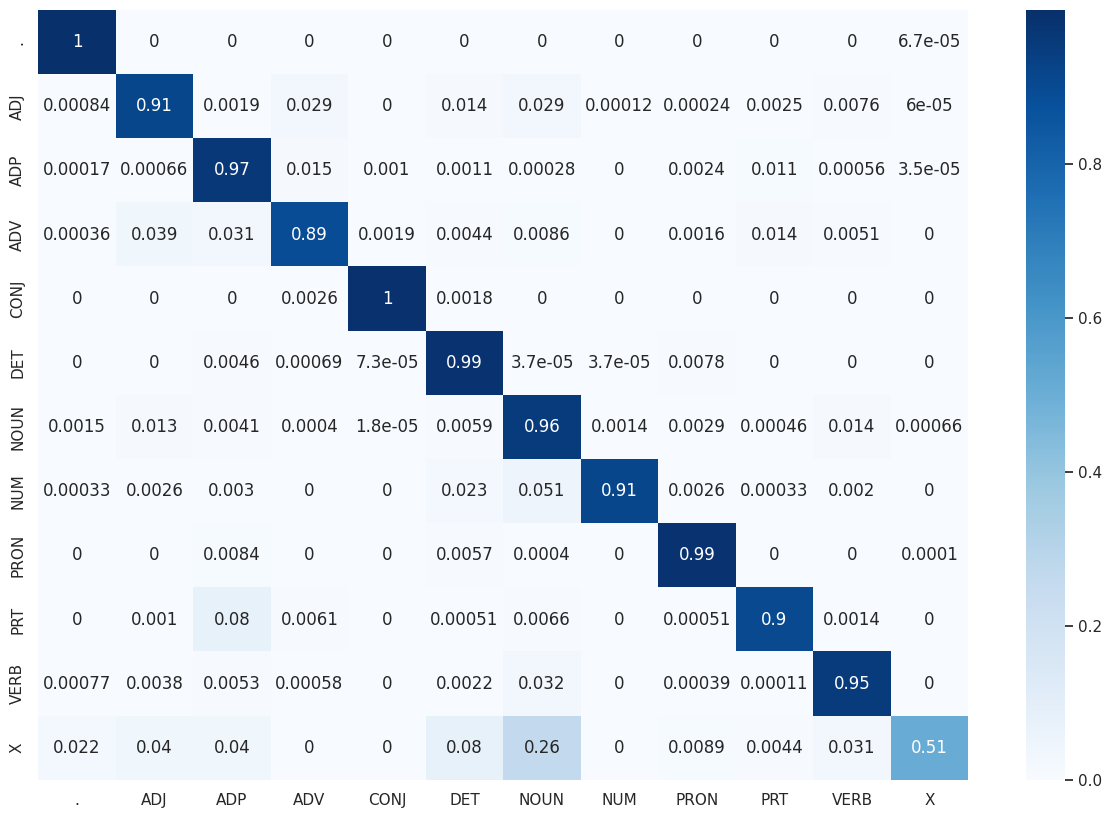

In [ ]:
# Start cross-validation

for fv in range(5):

    # Separate out the validation fold
    val_data = folds[fv]

    # Concatenate the training folds
    train_data = []
    for ft in range(5):
        if ft != fv:
            train_data += folds[ft]

    # Update vocab based on training data (these variables are used globally)
    VOCAB = buildVocab(train_data)
    N_VOCAB = len(VOCAB)
    id2word = lambda i : VOCAB[i]
    wordmap = {VOCAB[i]:i for i in range(N_VOCAB)}
    word2id = lambda i : wordmap[i]

    # Train
    tm, em = train(train_data)

    # Validate
    tags_true, tags_pred = evaluate(val_data, tm, em)

    # Compute metrics

    metric_labels = [i+1 for i in range(N_TAGS - 1)] # ignore the first dummy tag '-'

    cm = confusion_matrix(tags_true, tags_pred, normalize = "true", labels = metric_labels)
    acc = accuracy_score(tags_true, tags_pred)

    prec = precision_score(tags_true, tags_pred, average = None, labels = metric_labels)
    rec = recall_score(tags_true, tags_pred, average = None, labels = metric_labels)
    f1 = f1_score(tags_true, tags_pred, average = None, labels = metric_labels)

    f05 = fbeta_score(tags_true, tags_pred, beta = 0.5, average = "macro", labels = metric_labels)
    f2 = fbeta_score(tags_true, tags_pred, beta = 2, average = "macro", labels = metric_labels)

    # Tag-wise metrics
    print("Tag-wise precision:")
    printClasswise(prec)

    print("Tag-wise recall:")
    printClasswise(rec)

    print("Tag-wise F1:")
    printClasswise(f1)

    # Overall metrics for this fold
    print("Accuracy:", acc)
    print("Avg. precision:", mean(prec))
    print("Avg. recall:", mean(rec))
    print("Avg. f_0.5:", f05)
    print("Avg. f1:", mean(f1))
    print("Avg. f2:", f2)

    plotCM(cm)

    # Update global avg values
    avg_acc += acc
    avg_prec += mean(prec)
    avg_rec += mean(rec)
    avg_f1 += mean(f1)
    avg_f05 += f05
    avg_f2 += f2

    # Update tagwise metrics
    avg_prec_tagwise += prec
    avg_rec_tagwise += rec
    avg_f1_tagwise += f1

    # Update cm
    avg_cm += cm

# GUI

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr

# Define the function to take input and predict POS tags
def predict_pos(input_text):
    words = input_text.split()  # Tokenize input text into words
    words.insert(0, "^")  # Add start symbol '^' to the input sequence
    tag_ids = viterbi(tm, em, words)  # Perform Viterbi decoding using trained HMM model
    predicted_tags = [id2tag(t) for t in tag_ids]  # Convert tag IDs back to tag names
    return list(zip(words[1:], predicted_tags))  # Return word-tag pairs, excluding start symbol

# Create Gradio interface
interface = gr.Interface(
    fn=predict_pos,  # Function for prediction
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),  # Input textbox
    outputs=gr.Dataframe(headers=["Word", "POS Tag"], type="pandas"),  # Output as a dataframe
    title="POS Tagger using HMM",
    description="Enter a sentence and get the POS tags using a trained Hidden Markov Model (HMM).",
)

# Launch the Gradio interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d4f6f9ad3ad4bd60c9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
